# New expectation value design PoC

Takashi Imamichi and Ikko Hamamura (IBM Research - Tokyo)

## Motivation

We would like to realize a generic and simple interface for expectation values and their gradients.
It it necessary to be simple enough to incorporate various features and backends.
This could eventually be provided as Qiskit Runtime.
Other primitives, e.g., fidelity and histogram, will be covered by other proposals.

The current workflow with opflow to get an expectation value is as follows.
```python
# define the expectation value
state = StateFn(...) # can be a circuit-based state or defined via a statevector or dictionary
operator = # some opflow operator, e.g. PauliSumOp
expectation = StateFn(operator, is_measurement=True) @ state

# define how to evaluate
expectation_converter = # method to evaluate the expected value, e.g. PauliExpectation, CVaRExpectation, AerPauliExpectation, ...
circuit_sampler = CircuitSampler(backend)  # backend or simulator to execute the circuits

# constructs opflow objects needed to evaluate the expectation value
# e.g. creates circuits to measure in different Pauli bases
converted = expectation_converter.convert(expectation) 

# evaluate the circuits (optionally with parameters, if the state had free parameters so far)
sampled = circuit_sampler.convert(converted, parameters)

# get final result
result = sampled.eval()
```

Reference: [Expectation value re-design #6864](https://github.com/Qiskit/qiskit-terra/issues/6864)

We propose a new design of the expectation value to make it generic and simple.
Essentially, we aim at the following workflow.

```python
operator = ...
circuit = ...
expval = ExpectationValue(operator, circuit, backend)
grad = ExpectationValueGradient(expval) # or ExpectationValueGradient(operator, circuit, backend)
scipy.optimize.minimize(lambda x: expval.evaluate(x).value, lambda x: grad.evaluate(x).value)
```

### Planned Features

- Grouping algorithms of operators, `AbelienGrouper` (tensor product basis grouper) and grouper with entanglement measurements)
- Readout error mitigation algorithms, e.g., Complete mitigator, CTMP mitigator, [M3 mitigation](https://github.com/Qiskit-Partners/mthree)
- Gate error mitigation, e.g., zero noise extrapolation
- Classical shadow
- Entanglement forging
- Num. shots / circuits beyond backend/provider limit
- On-chip parallelization
- Bootstrap (sampling from probability distribution obtained from backend)
- Merge shots (execute the same circuits again and merge the shots to realize a larger number of shots)

## Outline of the new design

We propose an abstract class for expectation value and gradient.
An instance will be initialized with the following objects:

- `state` $\psi(\theta)$: a (parametrized) quantum circuit or a state vector to be converted into a quantum circuit.
- `observable` $H$: for simplicity, we allow opflow `PauliSumOp` (primitive is `SparsePauliOp`) or quantum_info operator `BaseOperator` that is compatible with `SparsePauliOp`.
- `backend`: Either `IBMQBackend` or `AerSimulator`. We don't support legacy simulator backends and BasicAer.
- (optional) `expval`: take an expectation value object as an input (e.g., gradient)

Instances of this class are immutable.
Users need to invoke the constructor to evaluate the expectation value of a different state or observable.

Users use `ExpectationValue.evaluate(parameters)` to obtain the expectation value.
The internal workflow consists of phases:

1. `ExpectationValue._preprocessing` generates quantum circuits corresponding to the pair of quantum state and observable. The circuits are transpiled for the backend and maybe left parametrized. This will be invoked on demand to avoid overhead of the constructor.
2. `ExpectationValue.evaluate(parameters)` puts parameter values to the transpiled circuits and executes them on the backend.
3. `ExpectationValue._postprocessing` interprets the results of the backend into an expectation value and other information as `ExpectationValueResult`.

Note: we allow `ExpectationValue.evaluate(parameters)` to process a set of parameters and the output will be `ExpectationValueArrayResult`. See an example later.

`ExpectationValueGradient` may have the same interface and/or it may take `ExpectationValue` object as an input of the constructor.

## Current status as PoC

The following classes and features have been implemented.

Expectation value classes
- `PauliExpectationValue`: expectation value for shot-based backends (both AerBackend and IBMQBackend) 
- `ExactExpectationValue`: exact expectation value with `SaveExpectationValueVariance` instruction supported only by Aer

Gradient of expectation value classes
- `FiniteDiffGradient`: finite difference gradient
- `ParameterShiftGradient`: parameter shift rule for the simple cases (parameters appears only once and they have coefficient 1)

Features
- Separate transpilation of ansatz and Pauli strings
  - A parameterized circuit corresponding to an ansatz is usually shared by Pauli strings that comprise the observable. This technique reduces the duplicate transpile of the shared part.
  - [transpile ansatz and pauli-lists separately in VQE #6454](https://github.com/Qiskit/qiskit-terra/pull/6454)
- Take a history of evaluations so that users can make a plot of optimization
  - Optimization algorithms e.g., [Scipy.opimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), should take care of the history. But, [OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) is not enough to include standard deviation and confidence interval of expectation values.
- Backend wrapper
  - Retry of job submission in case of cancel and/or network error
  - Split circuits if the size is larger than `max_experiments`
  - Copy circutis to realize users-set `shots` that is more than `max_shots`
  - Readout error mitigation (tensored, complete, M3)
    - Periodical calibration, e.g., calibration every 30 minutes

Questions
- Why does expval take care of backend as backend wrapper?
  - `QuantumInstance` of terra and `IBMQJobManager` (ManagedJob) of IBMQ provider can take care of only the split of circuits to satisfy `max_experiments`. But, as far as we know, there is no feature to realize `shots` more than `max_shots`. If this feature is implemented as part of IBMQ provider, it cannot be used for other backends, e.g., AQT and IonQ. Should it be part of terra?
  - We experimentally implemented preemptive readout error mitigation calibration, i.e., we put the calibration job between a set of jobs generated by the split or copy of circuits

TODOs
- Finalize the interface of the design
- Make a PR

In [1]:
%load_ext autoreload
%autoreload 2

# ExpectationValue

In [2]:
import numpy as np

In [3]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import PauliSumOp

observable = PauliSumOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)
print("observable")
print(observable)

ansatz = RealAmplitudes(num_qubits=2, reps=2)
print("\nansatz")
print(ansatz)

observable
-1.052373245772859 * II
+ 0.39793742484318045 * IZ
- 0.39793742484318045 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423156 * XX

ansatz
     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘


In [4]:
from qiskit.quantum_info import Statevector

expval = Statevector(ansatz.bind_parameters([0, 1, 1, 2, 3, 5])).expectation_value(
    observable.primitive
)
print(expval.real)

-1.284366511861733


/Users/ima/tasks/1_2021/qiskit/terra/qiskit/quantum_info/states/statevector.py:444: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  for z, x, coeff in zip(oper.table.Z, oper.table.X, oper.coeffs)


## ExpectationValue class

In [5]:
from qiskit.evaluators import PauliExpectationValue

### PauliExpectationValue

Evaluate the expectation value by sampling. This supports both AerSimulator and IBMQ backends.

In [6]:
from qiskit.providers.aer import AerSimulator

backend = AerSimulator()

In [7]:
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5], shos=1000)

ExpectationValueResult(value=-1.2643954491538492, variance=0.30478064129923726, confidence_interval=(-1.2933540186695045, -1.2354368796381938))

In [8]:
# pre-binding

circuit = ansatz.bind_parameters([0, 1, 1, 2, 3, 5])
expval = PauliExpectationValue(circuit, observable, backend=backend)
expval.evaluate()

ExpectationValueResult(value=-1.2534846729748215, variance=0.30840672058176705, confidence_interval=(-1.2826008893185852, -1.2243684566310578))

In [9]:
# multi prameters

expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]], shots=3000)

ExpectationValueArrayResult(values=array([-1.27750356, -1.32206984]), variances=array([0.30333885, 0.24123261]), confidence_intervals=array([[-1.29438487, -1.26062225],
       [-1.3367734 , -1.30736628]]))

In [10]:
# can pass ndarray
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate(np.array([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]]), shots=8192)

ExpectationValueArrayResult(values=array([-1.28481191, -1.31885668]), variances=array([0.29967444, 0.24262535]), confidence_intervals=array([[-1.29496649, -1.27465733],
       [-1.32778312, -1.30993024]]))

### Exact simulation by SaveExpectationValueVariance

In [11]:
from qiskit.evaluators import ExactExpectationValue

In [12]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2843665118617325, variance=0.26528532962023577, confidence_interval=None)

In [13]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate(np.array([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]]))

ExpectationValueArrayResult(values=array([-1.28436651, -1.31875263]), variances=array([0.26528533, 0.42691205]), confidence_intervals=array([None, None], dtype=object))

### Transpiled Circuits

In [14]:
from qiskit.test.mock import FakeBogota

backend = AerSimulator.from_backend(FakeBogota())

expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.set_transpile_options(initial_layout=[3, 2])
print(expval.evaluate([0, 1, 1, 2, 3, 5]))
for circ in expval.transpiled_circuits:
    print(circ)

ExpectationValueResult(value=-1.225751220713312, variance=0.32477994271602434, confidence_interval=(-1.2556129886610137, -1.1958894527656105))
global phase: π
                                                                »
ancilla_0 -> 0 ─────────────────────────────────────────────────»
                                                                »
ancilla_1 -> 1 ─────────────────────────────────────────────────»
               ┌────┐┌──────────────┐┌────┐┌────────┐┌───┐┌────┐»
      q_1 -> 2 ┤ √X ├┤ Rz(θ[1] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├┤ √X ├»
               ├────┤├──────────────┤├────┤├────────┤└─┬─┘├────┤»
      q_0 -> 3 ┤ √X ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├»
               └────┘└──────────────┘└────┘└────────┘     └────┘»
ancilla_2 -> 4 ─────────────────────────────────────────────────»
                                                                »
          c: 2/═════════════════════════════════════════════════»
                                                 

### Transpile options and Run options

In [15]:
expval = PauliExpectationValue(ansatz, observable, backend=backend)
# setter
expval.set_transpile_options(optimization_level=2)
expval.set_run_options(shots=100_000)
expval.evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2588173621730467, variance=0.31381753205614954, confidence_interval=(-1.2617898460690573, -1.2558448782770362))

In [16]:
# Method chain
expval.set_run_options(shots=8192).evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2491691880342957, variance=0.31748828290124875, confidence_interval=(-1.259614879193129, -1.2387234968754623))

In [17]:
# evaluate's option
expval.evaluate([0, 1, 1, 2, 3, 5], shots=300)

ExpectationValueResult(value=-1.2195858720581072, variance=0.32876036388678165, confidence_interval=(-1.275056325770024, -1.1641154183461904))

### Composite Evaluator

In [18]:
from qiskit.evaluators import JointEvaluator

In [19]:
len(expval.transpiled_circuits)

5

In [20]:
joint_evaluator = JointEvaluator([expval, expval, expval])  # can be different evaluators

In [21]:
len(joint_evaluator.transpiled_circuits)  # 5 × 3

15

In [22]:
joint_evaluator.evaluate([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8], [1, 2, 3, 5, 8, 13]])

CompositeResult(items=[ExpectationValueResult(value=-1.2272480906746472, variance=0.12777298271139736, confidence_interval=(-1.238418511590132, -1.2160776697591624)), ExpectationValueResult(value=-1.2272480906746472, variance=0.12777298271139736, confidence_interval=(-1.238418511590132, -1.2160776697591624)), ExpectationValueResult(value=-1.2272480906746472, variance=0.12777298271139736, confidence_interval=(-1.238418511590132, -1.2160776697591624))])

### Large number of shots

In [23]:
try:
    from qiskit import QuantumCircuit, QiskitError
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    from qiskit import IBMQ
    prov = IBMQ.load_account()
    ibmq_qasm_sim = prov.get_backend('ibmq_qasm_simulator')
    print(f"max_shots {backend.configuration().max_shots}")
    ibmq_qasm_sim.run(qc, shots=10000).result().get_counts()
except QiskitError as ex:
    print(ex.message)

max_shots 8192
Number of shots specified: 10000 exceeds max_shots property of the backend: 8192.


In [24]:
expval = PauliExpectationValue(ansatz, observable, backend=ibmq_qasm_sim)
expval.evaluate([0, 1, 1, 2, 3, 5], shots=10000)

ExpectationValueResult(value=-1.2882247208906341, variance=0.2995261141086044, confidence_interval=(-1.2974128839413253, -1.279036557839943))

### Readout error mitigation

In [25]:
from qiskit.evaluators.backends import ReadoutErrorMitigation

backend = AerSimulator.from_backend(FakeBogota())
mit_tensored = ReadoutErrorMitigation(
    backend, mitigation="tensored", refresh=600, shots=2000, mit_pattern=[[0], [1]]
)
mit_mthree = ReadoutErrorMitigation(
    backend, mitigation="mthree", refresh=600, shots=2000, qubits=[0, 1]
)
expval_raw = PauliExpectationValue(ansatz, observable, backend=backend)
expval_tensored = PauliExpectationValue(ansatz, observable, backend=mit_tensored)
expval_mthree = PauliExpectationValue(ansatz, observable, backend=mit_mthree)
shots = 4000
print(
    f"w/o mitigation shots={shots}, result={expval_raw.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)
print(
    f"w/ tensored mitigation shots={shots}, result={expval_tensored.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)
print(
    f"w/ M3 mitigation shots={shots}, result={expval_mthree.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)

w/o mitigation shots=4000, result=ExpectationValueResult(value=-1.2544919252232145, variance=0.31292875141394244, confidence_interval=(-1.2693368247969443, -1.2396470256494847))
w/ tensored mitigation shots=4000, result=ExpectationValueResult(value=-1.2828038316765074, variance=0.3039347743417342, confidence_interval=(-1.2974359722934574, -1.2681716910595573))
w/ M3 mitigation shots=4000, result=ExpectationValueResult(value=-1.2736400294126682, variance=0.30426174579278326, confidence_interval=(-1.2882816996068298, -1.2589983592185066))


### Gradient of expectation value

In [26]:
from qiskit.evaluators.expectation_value.expectation_value_gradient import (
    FiniteDiffGradient,
    ParameterShiftGradient,
)

In [27]:
parameters = [0, 1, 1, 2, 3, 5]

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = FiniteDiffGradient(exact_expval, 1e-8)
print(f"fin diff of exact {exact_findiff.evaluate(parameters).values}")

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = ParameterShiftGradient(exact_expval)
print(f"param shift of exact {exact_findiff.evaluate([0, 1, 1, 2, 3, 5]).values}")

shots = 2000
findiff = FiniteDiffGradient(expval_raw, 1e-1)
paramshift = ParameterShiftGradient(expval_raw)
print(f"fin diff w/o mit {findiff.evaluate(parameters, shots=shots).values}")
print(
    f"param shift w/o mit {paramshift.evaluate(parameters, shots=shots).values}"
)

findiff = FiniteDiffGradient(expval_mthree, 1e-1)
paramshift = ParameterShiftGradient(expval_mthree)
print(f"fin diff w/  mit {findiff.evaluate([0, 1, 1, 2, 3, 5], shots=shots).values}")
print(
    f"param shift w/  mit {paramshift.evaluate(parameters, shots=shots).values}"
)

fin diff of exact [ 0.28213347  0.42656751  0.20442583  0.42656749 -0.17291453  0.0589814 ]
param shift of exact [ 0.28213349  0.42656754  0.20442588  0.42656754 -0.17291452  0.05898141]
fin diff w/o mit [ 0.03400056  0.35468042 -0.0225191  -0.00933897 -0.38293762 -0.07825139]
param shift w/o mit [ 0.24897222  0.38652135  0.19106899  0.38817866 -0.14331993  0.05368115]
fin diff w/  mit [ 0.26239431  0.29226665  0.09738085  0.33411432 -0.14146992 -0.09708061]
param shift w/  mit [ 0.28675216  0.40320845  0.21501712  0.41117286 -0.16355165  0.0419902 ]


### VQE by Scipy optimizer

In [28]:
from scipy.optimize import minimize

shots = 1000
expval = PauliExpectationValue(ansatz, observable, backend=AerSimulator(), append=True)
paramshift = ParameterShiftGradient(expval)
# this may take a long time...
result = minimize(
    lambda x: expval.evaluate(x, shots=shots).value,
    np.zeros(6),
    jac=lambda x: paramshift.evaluate(x, shots=shots).values,
)
print(result)

      fun: -1.2753203352435865
 hess_inv: array([[ 1.02981002e+00, -1.44578694e-01, -2.74772820e-01,
        -1.69375145e-01,  7.68926135e-02,  2.65650004e-02],
       [-1.44578694e-01,  8.97373602e-01,  1.02053532e+00,
         1.47922078e-03, -1.09270416e-01, -1.75471773e-01],
       [-2.74772820e-01,  1.02053532e+00,  7.01190119e+00,
         1.06256473e+00, -5.63607585e-01, -5.91451354e-01],
       [-1.69375145e-01,  1.47922078e-03,  1.06256473e+00,
         1.10343644e+00, -1.66827239e-01, -1.85921851e-01],
       [ 7.68926135e-02, -1.09270416e-01, -5.63607585e-01,
        -1.66827239e-01,  1.11203128e+00,  8.03132670e-02],
       [ 2.65650004e-02, -1.75471773e-01, -5.91451354e-01,
        -1.85921851e-01,  8.03132670e-02,  1.05046372e+00]])
      jac: array([ 0.00728667,  0.06107162, -0.01600883,  0.05846878, -0.01289254,
        0.01110544])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 23
      nit: 3
     njev: 11
   status: 2
  success:

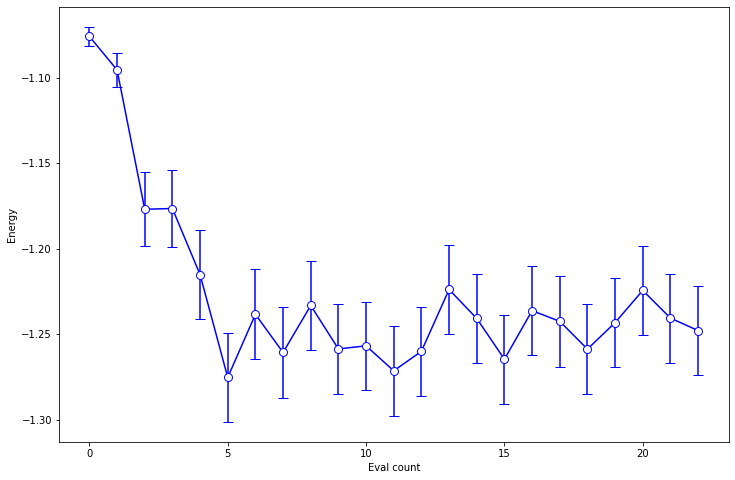

In [29]:
import matplotlib.pyplot as plt
from qiskit.evaluators.results import ExpectationValueResult

plt.figure(figsize=(12, 8))
y = [h.value for h in expval.history if isinstance(h, ExpectationValueResult)]
x = list(range(len(y)))
yerr = np.array(
    [
        tuple(abs(c - h.value) for c in h.confidence_interval)
        for h in expval.history
        if isinstance(h, ExpectationValueResult)
    ]
).transpose()
plt.plot(y, color="blue")
plt.errorbar(
    x,
    y,
    yerr=yerr,
    capsize=5,
    fmt="o",
    markersize=8,
    ecolor="blue",
    markeredgecolor="blue",
    color="w",
)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.show()